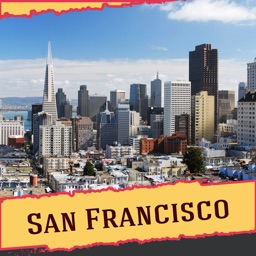

# Introduction
The goal of this notebook is to **prepare the data set and extract as much infromation** as possible. The underlying data is set of San Francisco criminal records. We see two types of variables:
* numeric variables like event occurence hour, latitude, longitude - these factors can be imemdiately used just after small preparation
* string factors like category and descript - I need to put more work for them to extract as much infromation as possible

The result of the nutebook will be cleaned, enriched, transformed data set with clusters attached.

**For clarity some code was hidde, click 'unhide' to see it.**

# 1.Data Preparation

I will prepare the data for further use (Cleansing topic is presented in my [other notebook](https://www.kaggle.com/jjmewtw/prices-cleaning-analysis-estimation-in-stages)).  First, loading some libraries:

In [ ]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import folium
import squarify
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from sklearn.decomposition import PCA
import difflib 
from textwrap import wrap
from mlxtend.preprocessing import minmax_scaling
from sklearn.mixture import GaussianMixture
from sklearn import metrics, mixture, cluster
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
print("Libraries loaded correctly.")

Second the data:

In [ ]:
df = pd.read_csv('../input/sanfranciso-crime-dataset/Police_Department_Incidents_-_Previous_Year__2016_.csv')
df_aux = pd.read_csv('../input/offences-in-us-with-penalties/AmericanOffencesPenalty.csv')
df_aux['Offence'] = df_aux['Offence'].str.upper()

print("The number of rows: " + format(df.shape[0]) + "The number of factors: " + format(df.shape[1]))

Mark categorical and numeric variables, check number of NA's:

In [ ]:
C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)

Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,7)) + " %")

Not a lot, but still needs to be cleaned. Only 'disctrict' variables has NA's, apply mode for it:

In [ ]:
df['PdDistrict'].fillna(df['PdDistrict'].mode()[0], inplace = True)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

Two functions for making data presentation neater:

In [ ]:
def highlight_cols(s, coldict):
    if s.name in coldict.keys():
        return ['background-color: {}'.format(coldict[s.name])] * len(s)
    return [''] * len(s)

def ExtractColumn(lst,j): 
    return [item[j] for item in lst] 

My cleaned data set:

In [ ]:
coldict = {'Category':'lightcoral','Descript':'lightcoral','PdDistrict':'lightcoral','Resolution':'lightcoral','DayOfWeek':'lightcoral','Address':'lightcoral', 
           'Date':'lightsalmon','Time':'lightsalmon','X':'lightsalmon','Y':'lightsalmon'}

df = df[['PdId','Category','Descript','PdDistrict','Resolution','DayOfWeek','Address','X','Y','Time','Date']]

df.iloc[0:5].style.apply(highlight_cols, coldict=coldict)

Some changes for date-related factors. Extracting minute and hour from 'time' and transofmring to float:

In [ ]:
df['Date'] = pd.Series(pd.to_datetime(df['Date']), index=df.index)
df['Minute'] = pd.Series(pd.to_datetime(df['Time']).dt.minute, index=df.index)+pd.Series(pd.to_datetime(df['Time']).dt.hour, index=df.index)*60
df['Hour'] = pd.Series(pd.to_datetime(df['Time']).dt.hour, index=df.index)
df['Time'] = pd.Series(pd.to_datetime(df['Time']).dt.time, index=df.index)

df['Month'] = pd.Series(df['Date'].dt.month, index=df.index)
df['Day'] = pd.Series(df['Date'].dt.day, index=df.index)

df['Date'] = pd.Series(pd.to_datetime(df['Date']), index=df.index)

C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)

Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

coldict = {'Category':'lightcoral','Descript':'lightcoral','PdDistrict':'lightcoral','Resolution':'lightcoral','DayOfWeek':'lightcoral','Address':'lightcoral', 
           'Date':'tomato','Time':'tomato','X':'lightsalmon','Y':'lightsalmon', 'Minute':'tomato', 'Hour':'tomato',  'Month':'tomato', 'Day':'tomato'}

df.iloc[0:5].style.apply(highlight_cols, coldict=coldict)

# 2.One-way analysis

Basic look at the dispersion of exposure regarding the factors groups (One-way topic is presented in my [other notebook](https://www.kaggle.com/jjmewtw/actuarial-study-eda-pca-cluster-estimation-0-88)).

In [ ]:
y = df['Category'].value_counts().head(25)
    
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('bmh')

labels = [ '\n'.join(wrap(l, 20)) for l in y.index]

color = plt.cm.Blues(np.linspace(0, 1, 15))
squarify.plot(sizes = y.values, label = labels, alpha=.8, color = color)
plt.title('Top 25 categories', fontsize = 20)

plt.axis('off')
plt.show()

Categories can be neatly divided. Let's look at descripts:

In [ ]:
y = df['Descript'].value_counts().head(30)
    
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('bmh')

labels = [ '\n'.join(wrap(l, 20)) for l in y.index]

color = plt.cm.Greens(np.linspace(0, 1, 15))
squarify.plot(sizes = y.values, label = labels, alpha=.8, color = color)
plt.title('Top 30 descripts', fontsize = 20)

plt.axis('off')
plt.show()

A bit more problematic, because there is no pre-defined form of descript, namely it depends on the fantasy of police officer.

In [ ]:
print("30 top used descripts corresponds to: " + format(round(sum(df['Descript'].value_counts().head(30))/sum(df['Descript'].value_counts()),3)*100)
     + "% of all descripts," +
    " while 100 top used descripts corresponds to: " + format(round(sum(df['Descript'].value_counts().head(100))/sum(df['Descript'].value_counts()),3)*100)
     + "% of all descripts.")

Last two variables which I find good to show: 'resolution' on the left and 'disctricts' on the right:

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), dpi=70, facecolor='w', edgecolor='k')
ax0, ax1= ax.flatten()

sns.set('talk', palette='colorblind')

font = {'family' : 'normal','weight' : 'normal','size'   : 12}

matplotlib.rc('font', **font)

color = plt.cm.twilight(np.linspace(0, 5, 100))

y = df['Resolution'].value_counts().head(5)
ax0.bar(y.index,y.values,color=color)
plt.setp(ax0.xaxis.get_majorticklabels(), rotation=75)
ax0.set_ylabel('Count');

y = df['PdDistrict'].value_counts()
ax1.bar(y.index,y.values,color=color)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=75)
ax1.set_ylabel('Count');

plt.tight_layout()
plt.show()

# 3.Features engineering

Let's boost this data set by adding some new variables (Feature engineering topic is presented in my [other notebook](https://www.kaggle.com/jjmewtw/prices-cleaning-analysis-estimation-in-stages)). 

First, matching string day of the week to ordinal variables from 1 to 7:

In [ ]:
DayOfWeek_map  = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}

df['DayOfWeek'] = df['DayOfWeek'].map(DayOfWeek_map)
print(DayOfWeek_map)

Second, check the frequency of occurence for given addresses and match it to the data:

In [ ]:
FrequentAddress = pd.DataFrame({'Frequent_Address':np.array(df.Address.value_counts()), 'Address':np.array(df.Address.value_counts().index)})
df = pd.merge(df,FrequentAddress,on='Address')
df=df.set_index('PdId')
FrequentAddress

Next, in the previous chapter we looked at the number of possible descripts, I will highlight top ten of them:

In [ ]:
xxx = pd.DataFrame(df.Descript.value_counts()/df.Descript.count()).head(10)
TopDescripts = list(xxx.index)
TopDescripts

Preferebly, we would apply fuzzy matching to connect our offences with the penalty size from American Law, in that way we would achieve the integer variable in palce of string strcuture. But this fuzzy matching is very heavy computation-wise:

In [ ]:
#df_aux['Offence'] = df_aux['Offence'].apply(lambda x: difflib.get_close_matches(x, df['Descript'],cutoff =0.6,n=1))
#df_dummy.merge(df_aux)

Next, the self-defined variable 'serious crime' with three integer value {0,1,2}. Value '2' for crimes with more than 10 years in jail, '0' for offences with no jail.

In [ ]:
Serious_Crime_map  = {'WEAPON LAWS':1,'WARRANTS':1,'NON-CRIMINAL':0, 'ASSAULT':2,
       'OTHER OFFENSES':0, 'MISSING PERSON':0, 'LARCENY/THEFT':1, 'BURGLARY':1,
       'STOLEN PROPERTY':0, 'ROBBERY':1, 'FRAUD':1, 'DRUG/NARCOTIC':2,
       'VEHICLE THEFT':1, 'RECOVERED VEHICLE':0, 'VANDALISM':1, 'ARSON':1,
       'PROSTITUTION':1, 'SECONDARY CODES':0, 'SUSPICIOUS OCC':0, 'DRUNKENNESS':0,
       'TRESPASS':1, 'SEX OFFENSES, NON FORCIBLE':1, 'SEX OFFENSES, FORCIBLE':2,
       'RUNAWAY':0, 'KIDNAPPING':2, 'DISORDERLY CONDUCT':0,
       'DRIVING UNDER THE INFLUENCE':1, 'FORGERY/COUNTERFEITING':1,
       'EMBEZZLEMENT':1, 'BRIBERY':1, 'FAMILY OFFENSES':1, 'GAMBLING':1,
       'SUICIDE':0, 'LIQUOR LAWS':0, 'EXTORTION':1, 'LOITERING':0, 'TREA':0,
       'BAD CHECKS':1, 'PORNOGRAPHY/OBSCENE MAT':1}

df['Serious_Crime'] = df['Category'].map(Serious_Crime_map)

Last modification, resolution binary defined on the basis of police verdict regarding the crime. '1' for offences finished with arrest, '0' for offences without it.

In [ ]:
df['Resolution_binary'] = np.where((df['Resolution'] == 'ARREST, BOOKED') | (df['Resolution'] == 'ARREST, CITED') | (df['Resolution'] == 'JUVENILE BOOKED') | (df['Resolution'] == 'PSYCHOPATHIC CASE'),1,0)

Finally, I transform the nominal variables into dummy set to keep their information.

In [ ]:
C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)

Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index) #+ ['Time']

OrdinalVariables = ['DayOfWeek']
NominalVariables = [x for x in CategoricalVariables if x not in OrdinalVariables]
ExcludeVariables = ['Descript','Address','Date','Time']
NominalVariables = [x for x in NominalVariables if x not in ExcludeVariables]

df_dummy = pd.get_dummies(df[NominalVariables], columns=NominalVariables)
df_numeric = df[NumericVariables]
df_numeric = minmax_scaling(df_numeric, columns=df_numeric.columns)
df_final = pd.merge(df_numeric,df_dummy,on='PdId')

print("Dummy transformation was successful")

# 4.Clustering

One of useful methods to understand the data is clustering (Clustering topic is presented in my [other notebook](https://www.kaggle.com/jjmewtw/clustering-k-means-hierarchical-debscan-ema)).  

First, let's look at the dependencies between numeric variables in this data set (Correlation topic is presented in my [other notebook](https://www.kaggle.com/jjmewtw/yt-pearson-spearman-distance-corr-rv-coef)).  

In [ ]:
SpearmanCorr = df_final[NumericVariables].corr(method="spearman")
matplotlib.pyplot.figure(figsize=(7,7))
sns.heatmap(SpearmanCorr, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

Obvious dependency between 'hour' and 'minute' as the first one is just a general version of the second one. Some dependecies between geographical factors. Below, the look on the dependency between resolution binary and its dummy versions:

In [ ]:
List_Resolution = ['Resolution_binary','Resolution_ARREST, BOOKED', 'Resolution_ARREST, CITED',
       'Resolution_CLEARED-CONTACT JUVENILE FOR MORE INFO',
       'Resolution_COMPLAINANT REFUSES TO PROSECUTE',
       'Resolution_EXCEPTIONAL CLEARANCE', 'Resolution_JUVENILE BOOKED',
       'Resolution_JUVENILE CITED', 'Resolution_JUVENILE DIVERTED',
       'Resolution_LOCATED', 'Resolution_NONE', 'Resolution_NOT PROSECUTED',
       'Resolution_PROSECUTED BY OUTSIDE AGENCY',
       'Resolution_PSYCHOPATHIC CASE', 'Resolution_UNFOUNDED']
SpearmanCorr = df_final[List_Resolution].corr(method="spearman")
x = SpearmanCorr[['Resolution_binary']]
matplotlib.pyplot.figure(figsize=(7,7))
sns.heatmap(x, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

Let's apply clustering. For this I chose 'Expectation-maximization algorithm' and decided to build spatial cluster by use of: 'Frequent_Address','X','Y','PdDistrict_BAYVIEW','PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE', 'PdDistrict_MISSION','PdDistrict_NORTHERN', 'PdDistrict_PARK', 'PdDistrict_RICHMOND','PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN'.

In [ ]:
df_spatial = df_final[['Frequent_Address','X','Y','PdDistrict_BAYVIEW',
       'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE', 'PdDistrict_MISSION',
       'PdDistrict_NORTHERN', 'PdDistrict_PARK', 'PdDistrict_RICHMOND',
       'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN']]
X = df_spatial.values

GM_n_components = np.arange(1, 10)
GM_models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in GM_n_components]

plt.figure(num=None, figsize=(8, 6), dpi=60, facecolor='w', edgecolor='r')
plt.plot(GM_n_components, [m.aic(X) for m in GM_models], label='AIC')
plt.tight_layout()
plt.legend(loc='best')
plt.xlabel('n_components');

Above methiod allows for estimation how many clusters are optimal for this method. Apaprently 6 is good choice.

In [ ]:
GM_n_classes = 6

GMcluster = mixture.GaussianMixture(n_components=GM_n_classes, covariance_type='full',random_state = 0)
GMcluster_fit = GMcluster.fit(df_spatial)
GMlabels = GMcluster_fit.predict(df_spatial)

print('Number of clusters: ' + format(len(np.unique(GMlabels))))

I look at the results by plotting 3D graph:

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(10, 40)
for l in np.unique(GMlabels):
    ax.scatter(X[GMlabels == l, 0], X[GMlabels == l, 1], X[GMlabels == l, 2],color=plt.cm.jet(float(l) / np.max(GMlabels + 1)),s=20, edgecolor='k')
plt.title('Expectation-maximization algorithm for spatial features clustering' )

plt.show()

And finally I merge this cluster to the data.

In [ ]:
df_final[['Spatial_Cluster']] = list(GMlabels)

Last, I apply the same method but for time using time-related variables like: 'DayOfWeek', 'Minute', 'Hour', 'Month', 'Day', 'Frequent_Address'. At the end also merging.

In [ ]:
df_time = df_final[['DayOfWeek', 'Minute', 'Hour', 'Month', 'Day', 'Frequent_Address']]
X = df_time.values

GM_n_classes = 4

GMcluster = mixture.GaussianMixture(n_components=GM_n_classes, covariance_type='full',random_state = 0)
GMcluster_fit = GMcluster.fit(df_time)
GMlabels = GMcluster_fit.predict(df_time)

df_final[['Time_Cluster']] = list(GMlabels)

# 5.Principial component analysis

The useful method to understand variability in the data set  (PCA topic is presented in my [other notebook](https://www.kaggle.com/jjmewtw/total-analysis-of-pca-sparse-pca-nmf-kernel-pca)).  

First, I fit regular PCA on the total data:

In [ ]:
pca = PCA().fit(df_final)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=70, facecolor='w', edgecolor='k')
ax0, ax1 = axes.flatten()

sns.set('talk', palette='colorblind')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

ax0.plot(np.cumsum(pca.explained_variance_ratio_)[0:20], marker='.')
ax0.set_xlabel('Number of components')
ax0.set_ylabel('Cumulative explained variance');

ax1.bar(range(20),pca.explained_variance_ratio_[0:20] )
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Explained variance');

plt.tight_layout()
plt.show()

Apparently,already 3 components give us good feeling about variability. I look what variables contribute the most to these 3 components:

In [ ]:
CompOne = pd.DataFrame(list(zip(df_final.columns,pca.components_[0])),columns=('Name','Contribution to Component 1'),index=range(1,len(df_final.columns)+1,1))
CompOne = CompOne[(CompOne['Contribution to Component 1']>0.05) | (CompOne['Contribution to Component 1']< -0.05)]
CompTwo = pd.DataFrame(list(zip(df_final.columns,pca.components_[1])),columns=('Name','Contribution to Component 2'),index=range(1,len(df_final.columns)+1,1))
CompTwo = CompTwo[(CompTwo['Contribution to Component 2']>0.05) | (CompTwo['Contribution to Component 2']< -0.05)]
CompThree = pd.DataFrame(list(zip(df_final.columns,pca.components_[2])),columns=('Name','Contribution to Component 3'),index=range(1,len(df_final.columns)+1,1))
CompThree = CompThree[(CompThree['Contribution to Component 3']>0.05) | (CompThree['Contribution to Component 3']< -0.05)]
#CompFour = pd.DataFrame(list(zip(df_final.columns,pca.components_[3])),columns=('Name','Contribution to Component 4'),index=range(1,len(df_final.columns)+1,1))
#CompFour = CompFour[(CompFour['Contribution to Component 4']>0.05) | (CompFour['Contribution to Component 4']< -0.05)]
#CompFive = pd.DataFrame(list(zip(df_final.columns,pca.components_[4])),columns=('Name','Contribution to Component 5'),index=range(1,len(df_final.columns)+1,1))
#CompFive = CompFive[(CompFive['Contribution to Component 5']>0.05) | (CompFive['Contribution to Component 5']< -0.05)]
#CompSix = pd.DataFrame(list(zip(df_final.columns,pca.components_[5])),columns=('Name','Contribution to Component 6'),index=range(1,len(df_final.columns)+1,1))
#CompSix = CompSix[(CompSix['Contribution to Component 6']>0.05) | (CompSix['Contribution to Component 6']< -0.05)]
PCA_top = pd.concat([CompOne,CompTwo,CompThree])
PCA_top

And presented factors alphabetically:

In [ ]:
sorted(list(PCA_top.Name.unique()))

Let's check how many components I need:

In [ ]:
n_PCA_70 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.7) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.7)
n_PCA_90 = np.size(np.cumsum(pca.explained_variance_ratio_)>0.9) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)>0.9)
print("Already " + format(n_PCA_70) + " components cover 70% of variance. " + format(n_PCA_90) + " components cover 90%.")

And last let's plot contribution of numeric variables (you can do it as well with all variables, but it will look messy).

In [ ]:
pca = PCA(4).fit((df_final[NumericVariables]))

X_pca=pca.transform((df_final[NumericVariables])) 

plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3,4],['1st Comp','2nd Comp','3rd Comp','4th Comp'],fontsize=12)
plt.colorbar()
plt.xticks([0,1,2,3,4,5,6,7,8,9],NumericVariables,fontsize=10,rotation=30)
plt.tight_layout()
plt.show()

# 6.Final data description

At this stage, I have cleaned, enriched data with plotted dependencies and trends. Please find the data set below:
* first group are time-related factors
* second group are factor defined by me, engineered ones
* third group (X and Y) are variables latitude and longitude
* fourth big group without color are dummy variables
* at the very end fifth group are two clusters which were defined

In [ ]:
coldict = {'Category':'lightcoral','Descript':'lightcoral','PdDistrict':'lightcoral','Resolution':'lightcoral','DayOfWeek':'tomato','Address':'lightcoral', 
           'Date':'tomato','Time':'tomato','X':'lightsalmon','Y':'lightsalmon', 'Minute':'tomato', 'Hour':'tomato',  'Month':'tomato', 'Day':'tomato',
          'Frequent_Address':'orange','Serious_Crime':'orange','Resolution_binary':'orange','Spatial_Cluster':'yellow','Time_Cluster':'yellow'}

df_final.iloc[0:10].style.apply(highlight_cols, coldict=coldict)

For this data set, we can put every factor out-of-bag and treat as response. 

It may then look like calculator, where user puts characteristics of situation and tries to find the respective results. 

**In the next notebook I will use following variables as response in separate analyzes:**
* Minute - I predict the time of the given crime. I exclude for this 'time cluster' and 'hour' but leave 'day of week' and 'day' which corresponds to the day of month
* Resolution_binary - I predict whether the given crime will finish with arrest or not. I leave out all resolution-related dummies
* Serious_Crime - I will check whther the crime can be defined as serious leaving out all category-related variables
* Spatial_Cluster - I will predict what type of crime appears in the given location. All spatial variables will be excluded

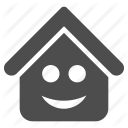

**Please upvote if you liked it.**